# Model Evaluation (CelebA)

In [1]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from tqdm import tqdm

import sys
sys.path.append('../src/data')
sys.path.append('../src/')
sys.path.append('../src/utils')

from datasets import CelebaDataset, WFLWDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from trainer import Trainer

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")
def generate_predictions(model,
                         dataloader,
                         forward_args = {},
                         numclasses = 5*2,
                         device = torch.device('cuda')):
    y_pred = np.zeros((0,int(numclasses/2), 2))
    y = np.zeros((0,int(numclasses/2), 2))
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            inputs = batch['image'].to(device=device)
            labels = batch['landmarks'].numpy()

            outputs = model(inputs, **forward_args).cpu().view(-1, int(numclasses/2), 2).numpy()  # (batch_size, length, num_classes)
            
            y_pred = np.concatenate((y_pred, outputs), axis=0)
            y = np.concatenate((y, labels), axis=0)
                
    return y_pred, y

Running on device: cuda


In [3]:
celeba_data_loc = '/home/data/celeba/'

train_dataset = CelebaDataset(celeba_data_loc + 'landmarks_train.csv', celeba_data_loc + 'attr_train.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
val_dataset = CelebaDataset(celeba_data_loc + 'landmarks_val.csv', celeba_data_loc + 'attr_val.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
test_dataset = CelebaDataset(celeba_data_loc + 'landmarks_test.csv', celeba_data_loc + 'attr_test.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))

trainloader_params = {
    'dataset': train_dataset,
    'batch_size': 8,
    'shuffle': False
}
train_dataloader = DataLoader(**trainloader_params)

valloader_params = {
    'dataset': val_dataset,
    'batch_size': 4,
    'shuffle': False
}
val_dataloader = DataLoader(**valloader_params)

testloader_params = {
    'dataset': test_dataset,
    'batch_size': 4,
    'shuffle': False
}
test_dataloader = DataLoader(**testloader_params)

# Load Model if outputs already saved

In [4]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

celeba_baseline_resnet_1/             wflw_baseline_resnet_pretrain_1/
celeba_baseline_resnet_nopretrain_1/  wflw_baseline_resnet_pretrain_2/
celeba_baseline_simplenet_1/          wflw_baseline_simplenet_1/
wflw_baseline_resnet_nopretrain_1/


In [5]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2"

model.pt  optimizer.pt  results.csv


In [6]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2/results.csv"
model_results = pd.read_csv(model_path)

In [7]:
num_landmarks = 5
y = model_results['y'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
y_pred = model_results['y_pred'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
print(y.shape, y_pred.shape)

# To convert into (NxD) just change view

(19962, 5, 2) (19962, 5, 2)


In [8]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=10, marker='.', c='b')
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


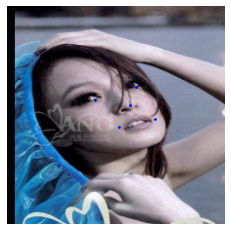

Truth


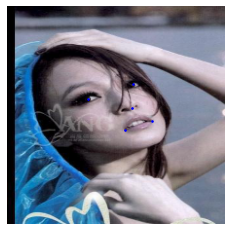

tensor([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          1, -1, -1,  1]], dtype=torch.int32)


In [36]:
img_num = 2300

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()
print(sample['attributes'])

In [34]:
attribute_names = pd.read_csv(celeba_data_loc + 'list_attr_celeba.txt', delim_whitespace=True)
attribute_names = attribute_names.columns[1:]

In [105]:
attribute_df = pd.read_csv(celeba_data_loc+'attr_test.csv')
class_counts = attribute_df.iloc[:, 1:].apply(pd.Series.value_counts)
biased_classes = class_counts.idxmax()
class_counts

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
-1,17968,14284,10064,15917,19539,16853,13434,15730,14540,17302,...,19036,9975,15772,12695,15837,19123,9544,17209,18563,4848
1,1994,5678,9898,4045,423,3109,6528,4232,5422,2660,...,926,9987,4190,7267,4125,839,10418,2753,1399,15114


In [107]:
class_counts.max() / class_counts.sum()

5_o_Clock_Shadow       0.900110
Arched_Eyebrows        0.715560
Attractive             0.504158
Bags_Under_Eyes        0.797365
Bald                   0.978810
Bangs                  0.844254
Big_Lips               0.672979
Big_Nose               0.787997
Black_Hair             0.728384
Blond_Hair             0.866747
Blurry                 0.949404
Brown_Hair             0.820309
Bushy_Eyebrows         0.870454
Chubby                 0.946999
Double_Chin            0.954263
Eyeglasses             0.935427
Goatee                 0.954163
Gray_Hair              0.968139
Heavy_Makeup           0.595031
High_Cheekbones        0.518185
Male                   0.613516
Mouth_Slightly_Open    0.504909
Mustache               0.961327
Narrow_Eyes            0.851318
No_Beard               0.853672
Oval_Face              0.704388
Pale_Skin              0.957920
Pointy_Nose            0.714257
Receding_Hairline      0.915139
Rosy_Cheeks            0.928264
Sideburns              0.953612
Smiling 

In [35]:
# load data and predictions
x = pd.read_csv(celeba_data_loc+'attr_test.csv').values[:, 1:]
y_hat = y_pred

num_samples, num_features = x.shape
assert(y_hat.shape == y.shape)

In [36]:
# define d to be either interocular distance or bounding box diagonal length
d = np.array([1*2**0.5]*num_samples)

In [198]:
"""
Z = list of lists, where each entry is [sensitive attribute column number, majority condition]
alpha = failure rate threshold   
calculate_landmark: if True, calculates certain bias metrics overall and per landmark. if false, only overall
"""
counts = np.sum(x, axis=0)
maj = np.where(counts > 0, 1, -1)
Z = [[i,maj[i]] for i in range(num_features)]

alpha = 0.0005
beta = 0.003
# calculate_landmark = True

In [199]:
print(maj)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]


In [200]:
""" Accuracy Metrics: Normalized Mean Error (NME) and CED/AUC/FR
y, y_hat have dimensions of n x m
d is the interocular distance
"""

def calc_nme_images(y_hat, y, m, d):
    # Output: NME of each image over all landmarks (size n)
    return np.square(np.linalg.norm(y_hat-y, axis=(1,2))) / d 

def calc_nme_landmark(y_hat, y, m, d):
    # Output: NME of each image for each facial landmark (size n x m/2)
    nme = np.square(y_hat-y) / d[:, np.newaxis, np.newaxis] 
    return np.mean(nme, axis=2)

def calc_total_nme(nme):
    # Output: average NME across all images
    return np.mean(nme, axis=0)

def create_ced(nme):
    # Output: plot of the CED
    x = np.sort(nme)
    y = np.arange(nme.shape[0]) / float(nme.shape[0])
    plt.xlabel('Normalized Mean Error (NME)')
    plt.ylabel('Percent of Samples')
  
    plt.title('Plot of Cumulative Error Distribution (CED) Curve')
    plt.plot(x, y, marker='o')
    plt.show

def calc_auc(nme, alpha):
    # Output: percentage of samples with nme=0 to alpha
    num_under_alpha = np.where(nme < alpha, 1, 0)
    return np.sum(num_under_alpha) / nme.shape[0]

def calc_fr(nme, alpha):
    # Output: failure rate, where failure is defined w.r.t a threshold, alpha (percent of samples with nme>alpha)
    return 1-calc_auc(nme, alpha)

In [201]:
nme_images = calc_nme_images(y_hat, y, num_landmarks, d)
nme_landmark = calc_nme_landmark(y_hat, y, num_landmarks, d)
total_nme = calc_total_nme(nme_images)
total_nme_landmark = calc_total_nme(nme_landmark)
fr = calc_fr(nme_images, alpha)

print('Average Normalized Mean Error:', total_nme, '\n')
print('Average Normalized Mean Error Per Landmark')
for i in range(num_landmarks):
    print(f'Landmark {i}: {total_nme_landmark[i]}')
print('\n')
print(f'Failure Rate Threshold at {alpha}: {fr}')

Average Normalized Mean Error: 0.0008948775928394106 

Average Normalized Mean Error Per Landmark
Landmark 0: 7.772001540075074e-05
Landmark 1: 8.381275071640747e-05
Landmark 2: 9.114614657832776e-05
Landmark 3: 8.950694691685923e-05
Landmark 4: 0.00010525293680735962


Failure Rate Threshold at 0.0005: 0.25147780783488627


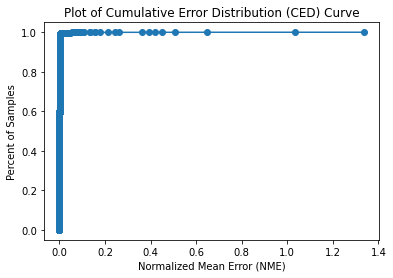

In [202]:
ced = create_ced(nme_images)

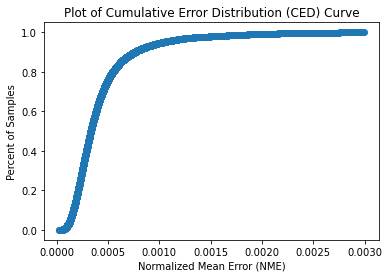

In [203]:
no_outliers = nme_images[np.where(nme_images<beta)]
ced = create_ced(no_outliers)

In [204]:
"""Bias Metrics: Majority/Minority Difference in Error/Failure (MMD)"""
def calc_mmd_err(majority, minority):
    difference = np.mean(majority, axis=0) - np.mean(minority, axis=0)
    return difference

def calc_mmd_fr(majority, minority, alpha):
    difference = calc_fr(majority, alpha) - calc_fr(minority, alpha)
    return difference

In [205]:
""" Within each loop:
z = sensitive attribute group (as column number)
maj = value of majority group
nme = num_samples dimension tensor
"""

mmd_err = {}
mmd_fr = {}


# if calculate_landmark:
#     mmd_error_landmarks = {}

# calculates MMD Error and MMD Failure averaged across all landmarks
for z, maj in Z:
    majority = nme_images[np.where(x[:, z] == maj)] # size # images in majority
    minority = nme_images[np.where(x[:, z] != maj)] # size # images in minority

    mmd_err[z] = calc_mmd_err(majority, minority)
    mmd_fr[z] = calc_mmd_fr(majority, minority, alpha)

# calculates MMD Error for each landmark    
# if calculate_landmark:
#     for z, maj in Z:
#         majority = nme_landmark[np.where(x[:, z] == maj)] # size # images in majority x m/2
#         minority = nme_landmark[np.where(x[:, z] != maj)] # size # images in minority x m/2
#         mmd_error_landmarks[z] = calc_mmd_err(majority, minority)

In [206]:
# 

print('MMD in Error per Attribute')
for z, error in mmd_err.items():
    print(f'Attribute {z} ({attribute_names[z]}): {error}')

MMD in Error per Attribute
Attribute 0 (5_o_Clock_Shadow): 0.0005132820350351442
Attribute 1 (Arched_Eyebrows): 0.0002876586054642822
Attribute 2 (Attractive): 0.00018082639745472064
Attribute 3 (Bags_Under_Eyes): 0.0003022405009729056
Attribute 4 (Bald): -0.000858247937570784
Attribute 5 (Bangs): 0.00021935290414994992
Attribute 6 (Big_Lips): -0.00038495515711390834
Attribute 7 (Big_Nose): 0.00031024805107380204
Attribute 8 (Black_Hair): 0.0003967618814244414
Attribute 9 (Blond_Hair): -0.0005396888164235712
Attribute 10 (Blurry): -0.0010579074833921387
Attribute 11 (Brown_Hair): 0.0005781417503919041
Attribute 12 (Bushy_Eyebrows): 0.0005436257052903631
Attribute 13 (Chubby): 0.00022887309212855532
Attribute 14 (Double_Chin): -0.00017868003938791596
Attribute 15 (Eyeglasses): -0.0004997203648277588
Attribute 16 (Goatee): 0.00032196154503510543
Attribute 17 (Gray_Hair): 0.00036339167441354586
Attribute 18 (Heavy_Makeup): 9.91147101001282e-05
Attribute 19 (High_Cheekbones): 0.00089715282

In [207]:
print('MMD in Failure Rate')
for z, error in mmd_fr.items():
    print(f'Attribute {z} ({attribute_names[z]}) : {(error * 100):.3f} % | majority class: {Z[z][1]}')

MMD in Failure Rate
Attribute 0 (5_o_Clock_Shadow) : 4.594 % | majority class: -1
Attribute 1 (Arched_Eyebrows) : 11.418 % | majority class: -1
Attribute 2 (Attractive) : 15.213 % | majority class: -1
Attribute 3 (Bags_Under_Eyes) : 1.340 % | majority class: -1
Attribute 4 (Bald) : -9.570 % | majority class: -1
Attribute 5 (Bangs) : 4.718 % | majority class: -1
Attribute 6 (Big_Lips) : 3.088 % | majority class: -1
Attribute 7 (Big_Nose) : -3.741 % | majority class: -1
Attribute 8 (Black_Hair) : 0.621 % | majority class: -1
Attribute 9 (Blond_Hair) : 7.631 % | majority class: -1
Attribute 10 (Blurry) : -20.128 % | majority class: -1
Attribute 11 (Brown_Hair) : 7.580 % | majority class: -1
Attribute 12 (Bushy_Eyebrows) : 3.568 % | majority class: -1
Attribute 13 (Chubby) : -9.276 % | majority class: -1
Attribute 14 (Double_Chin) : -4.408 % | majority class: -1
Attribute 15 (Eyeglasses) : -20.721 % | majority class: -1
Attribute 16 (Goatee) : -8.579 % | majority class: -1
Attribute 17 (Gr

# Train Model (only run once per model)

## Evaluate CelebA

In [9]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

celeba_baseline_resnet_1/             wflw_baseline_resnet_pretrain_1/
celeba_baseline_resnet_nopretrain_1/  wflw_baseline_resnet_pretrain_2/
celeba_baseline_simplenet_1/          wflw_baseline_simplenet_1/
wflw_baseline_resnet_nopretrain_1/


In [127]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2"

model.pt  optimizer.pt  results.csv


In [16]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2/model.pt"
model = torch.load(model_path).to(device)

In [61]:
y_pred, y = generate_predictions(model, test_dataloader, numclasses=5*2, device=device)

  0%|          | 4/4991 [00:00<05:02, 16.49it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 8/4991 [00:00<05:18, 15.66it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 12/4991 [00:00<04:59, 16.61it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 14/4991 [00:00<05:14, 15.84it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 18/4991 [00:01<05:28, 15.14it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 20/4991 [00:01<05:21, 15.45it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 22/4991 [00:01<06:56, 11.94it/s]

torch.Size([4, 3, 224, 224])


  0%|          | 24/4991 [00:01<08:38,  9.57it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 28/4991 [00:02<07:58, 10.38it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 30/4991 [00:02<14:18,  5.78it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 31/4991 [00:03<08:04, 10.23it/s]

torch.Size([4, 3, 224, 224])


KeyboardInterrupt: 

In [134]:
data_dict = {
    'y': y.flatten(),
    'y_pred': y_pred.flatten()
}

pred_df = pd.DataFrame(data_dict)
results_csv_path = model_path.replace('model.pt', f'results.csv')
pred_df.to_csv(results_csv_path, index=False)

# Print CelebA predictions

In [107]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=20, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


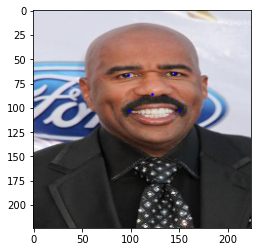

Truth


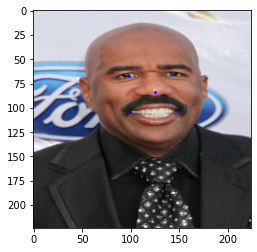

In [173]:
img_num = 2004

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()